<a href="https://colab.research.google.com/github/OleksiiLatypov/DS_HW_1/blob/master/DS_HW_10/DS_HW_10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

from keras.layers import Flatten, Dense
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.optimizers import Adam
import seaborn as sns

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
print(f'Shape of train images: {train_images.shape}')
print(f'Shape of test images: {train_images.shape}')


Shape of train images: (60000, 28, 28)
Shape of test images: (60000, 28, 28)


Resizing: VGG16 expects input images to have a fixed size of (224, 224, 3). Fashion MNIST images are initially 28x28 pixels in size and grayscale (1 channel). Resizing them to (32, 32) and then repeating the channel three times effectively converts them to the required size of (32, 32, 3). This resizing step ensures that the images have the same dimensions as what VGG16 expects.

In [5]:
# Resize the images 32*32 as required by VGG16

train_images = tf.image.resize(np.array(train_images)[..., tf.newaxis], (32, 32))
train_images = np.repeat(train_images, 3, axis=-1)
test_images = tf.image.resize(np.array(test_images)[..., tf.newaxis], (32, 32))
test_images = np.repeat(test_images, 3, axis=-1)

# Change pixel values from (0, 255) to (0, 1)
train_images = np.array(train_images) / 255.0
test_images = np.array(test_images) / 255.0

In [6]:
print(f'Shape of train images for VGG: {train_images.shape}')
print(f'Shape of test images for VGG: {train_images.shape}')

Shape of train images for VGG: (60000, 32, 32, 3)
Shape of test images for VGG: (60000, 32, 32, 3)


In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker' , 'Bag', 'Ankle boot']


In [8]:
# Converting Labels to one hot encoded format

unique_classes = np.unique(train_labels)
NUM_CLASSES = unique_classes.shape[0]

def to_categorical(labels, num_classes):
  return tf.keras.utils.to_categorical(labels, num_classes)
train_labels = to_categorical(train_labels, NUM_CLASSES)
test_labels = to_categorical(test_labels, NUM_CLASSES)
print(train_labels.shape)
print(test_labels.shape)

(60000, 10)
(10000, 10)


In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') - logs.get('val_accuracy') >= 0.05 and epoch > 5:
      # Stop if threshold is met
      print(f"\nThe difference between train accuracy and validation more than 5% so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

In [11]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

In [12]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

In [13]:
model_vgg = Sequential()
model_vgg.add(conv_base)
model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation="relu"))
model_vgg.add(Dense(10, activation="softmax"))

In [14]:
model_vgg.compile(optimizer=Adam(learning_rate=0.003), loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg = model_vgg.fit(
    train_images,
    train_labels,
    epochs=25,
    verbose=1,
    batch_size=250,
    validation_split=0.2,
    callbacks=[callbacks, reduce_lr, early_stopping]
)

Epoch 1/25
  6/192 [..............................] - ETA: 4s - loss: 1.7496 - accuracy: 0.4380

192/192 [==============================] - 18s 38ms/step - loss: 0.5692 - accuracy: 0.7985 - val_loss: 0.4702 - val_accuracy: 0.8316 - lr: 0.0030
Epoch 2/25
192/192 [==============================] - 8s 41ms/step - loss: 0.4169 - accuracy: 0.8475 - val_loss: 0.4278 - val_accuracy: 0.8388 - lr: 0.0030
Epoch 3/25
192/192 [==============================] - 8s 42ms/step - loss: 0.3822 - accuracy: 0.8598 - val_loss: 0.4303 - val_accuracy: 0.8427 - lr: 0.0030
Epoch 4/25
192/192 [==============================] - 8s 42ms/step - loss: 0.3573 - accuracy: 0.8686 - val_loss: 0.3909 - val_accuracy: 0.8568 - lr: 0.0030
Epoch 5/25
192/192 [==============================] - 7s 34ms/step - loss: 0.3404 - accuracy: 0.8741 - val_loss: 0.3846 - val_accuracy: 0.8582 - lr: 0.0030
Epoch 6/25
192/192 [==============================] - 7s 34ms/step - loss: 0.3239 - accuracy: 0.8794 - val_loss: 0.3888 - val_accuracy: 0.8598 - lr: 0.0030
Epoch 7/25
192/192 [==============================] - 7s 34ms/step - loss:

In [15]:
model_vgg.evaluate(test_images, test_labels)

313/313 [==============================] - 4s 10ms/step - loss: 0.3500 - accuracy: 0.8790


[0.34995579719543457, 0.8790000081062317]

In [16]:
result = pd.DataFrame(history_vgg.history)
result.head()
last_lr = history_vgg.history['lr'][-1]


[]

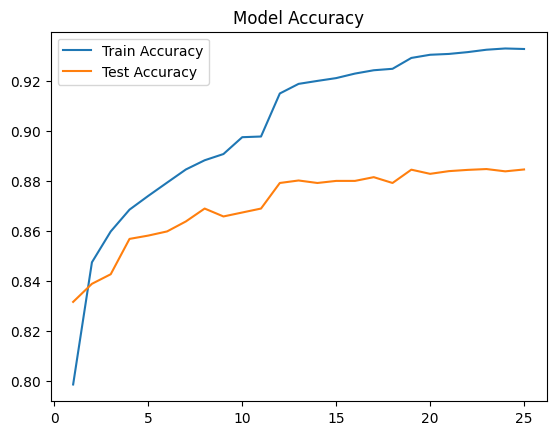

In [17]:
plt.plot(list(range(1, result.shape[0]+1)), result['accuracy'], label='Train Accuracy')
plt.plot(list(range(1, result.shape[0] + 1)), result['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.plot()

[]

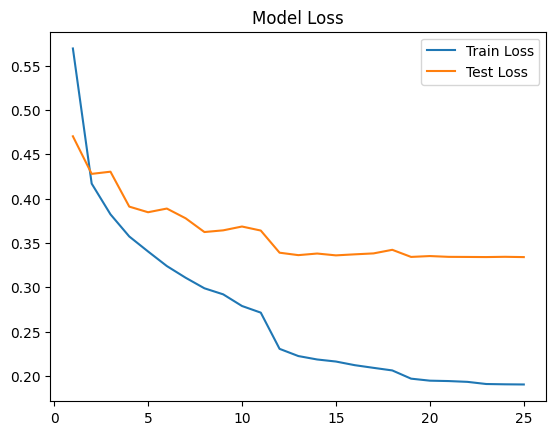

In [18]:
plt.plot(list(range(1, result.shape[0]+1)), result['loss'], label='Train Loss')
plt.plot(list(range(1, result.shape[0] + 1)), result['val_loss'], label='Test Loss')
plt.legend()
plt.title('Model Loss')
plt.plot()

In [19]:
# overview of the model's architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [20]:
for i , layer in enumerate(model_vgg.layers):
  layer._name += 'layer_' + str(i)
  #print(layer._name)

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
conv_base._trainable = True
set_trainable = False
for layer in conv_base.layers:
  #print(layer.name)
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

modified_model = tf.keras.models.Sequential([
    conv_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax'),
])



In [21]:
model_vgg.compile(
    optimizer=Adam(learning_rate=last_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history_vgg = model_vgg.fit(train_images,
                                 train_labels,
                                 epochs=25,
                                 verbose=1,
                                 batch_size=250,
                                 validation_split=0.2,
                                 callbacks=[callbacks, reduce_lr, early_stopping])

Epoch 1/25
  5/192 [..............................] - ETA: 7s - loss: 0.1871 - accuracy: 0.9400

192/192 [==============================] - 8s 37ms/step - loss: 0.1904 - accuracy: 0.9333 - val_loss: 0.3342 - val_accuracy: 0.8842 - lr: 2.4000e-05
Epoch 2/25
192/192 [==============================] - 8s 41ms/step - loss: 0.1901 - accuracy: 0.9332 - val_loss: 0.3342 - val_accuracy: 0.8848 - lr: 2.4000e-05
Epoch 3/25
192/192 [==============================] - 7s 36ms/step - loss: 0.1900 - accuracy: 0.9335 - val_loss: 0.3342 - val_accuracy: 0.8841 - lr: 2.4000e-05
Epoch 4/25
192/192 [==============================] - 8s 42ms/step - loss: 0.1899 - accuracy: 0.9334 - val_loss: 0.3341 - val_accuracy: 0.8843 - lr: 2.4000e-05
Epoch 5/25
192/192 [==============================] - 7s 34ms/step - loss: 0.1896 - accuracy: 0.9335 - val_loss: 0.3346 - val_accuracy: 0.8841 - lr: 2.4000e-05
Epoch 6/25
192/192 [==============================] - 7s 34ms/step - loss: 0.1895 - accuracy: 0.9332 - val_loss: 0.3350 - val_accuracy: 0.8833 - lr: 2.4000e-05
Epoch 7/25
192/192 [==============================]

In [22]:
model_vgg.evaluate(test_images, test_labels)

313/313 [==============================] - 3s 9ms/step - loss: 0.3500 - accuracy: 0.8805


[0.35002031922340393, 0.8805000185966492]

313/313 [==============================] - 3s 8ms/step


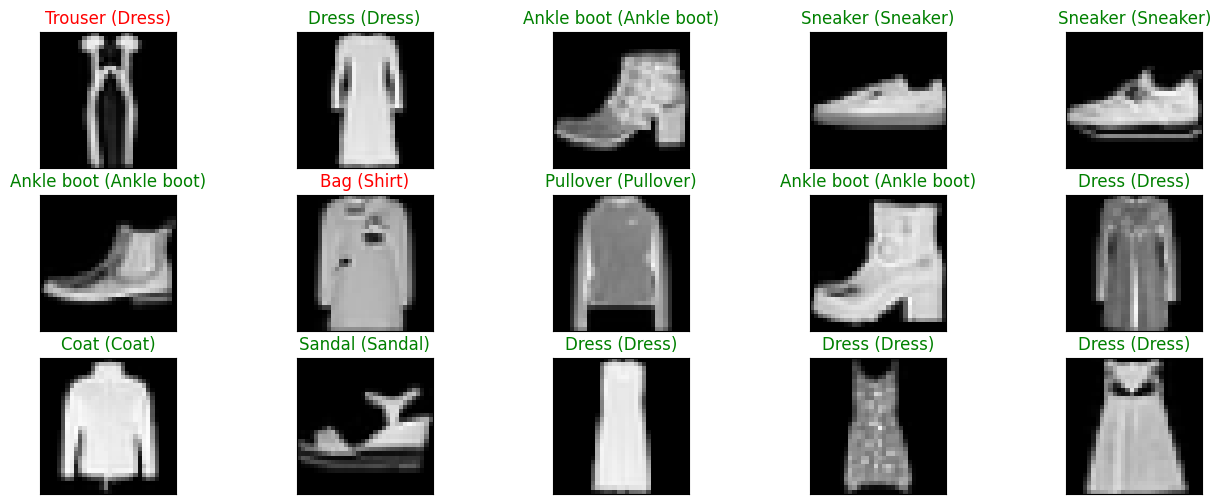

In [24]:
predictions = model_vgg.predict(test_images)


figure = plt.figure(figsize=(16, 6))
display_images = np.random.choice(test_images.shape[0], size=15, replace=False)
for i, index in enumerate(display_images):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(test_images[index], cmap='gray')
    predict_index = np.argmax(predictions[index])
    #print(f'{predict_index}: {class_names[predict_index]}')
    true_index = np.argmax(test_labels[index])
    ax.set_title("{} ({})".format(class_names[predict_index],
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

In [30]:
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.85      0.84      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.82      0.80      0.81      1000
       Dress       0.85      0.85      0.85      1000
        Coat       0.77      0.80      0.78      1000
      Sandal       0.96      0.96      0.96      1000
       Shirt       0.70      0.68      0.69      1000
     Sneaker       0.95      0.96      0.95      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



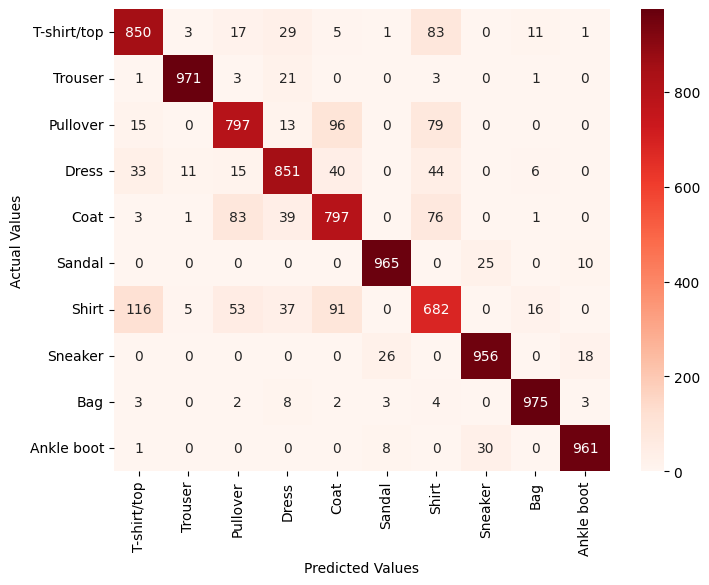

In [33]:
cm = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

Як бачимо VGG16 має точніть на 2% нижче за FCNN (з попереднього ДЗ) і на 6% нижче ніж CNN з частини 1. Згідно результатів Classification Report і Confusion Matrix наша нейромережа добре справилася з розпізнаванням усіх зображень одягу. Найбільшу точність вона показала при розпізнаванні зображень Bag, Trouser, а найменшу для зображень Shirt. VGG16 — це глибока модель із великою кількістю параметрів, розроблена для більш складних наборів даних, таких як ImageNet, який містить мільйони зображень із високою роздільною здатністю та різноманітним вмістом. З іншого боку, Fashion MNIST — це відносно простий набір даних із невеликими зображеннями у градаціях сірого (28x28 пікселів) і меншою кількістю класів (10 категорій одягу). Висока ємність VGG16 може призвести до переобладнання цього менш складного набору даних.